### imports

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# datasets
from sklearn.datasets import load_iris
from ucimlrepo import fetch_ucirepo 
from io import StringIO

# discretization
from libraries.caimcaim import CAIMD # https://github.com/airysen/caimcaim/blob/master/caimcaim/caimcaim.py

# grid search
from sklearn.model_selection import GridSearchCV

# objective function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# regularization
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

import torch

# evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

### datasets
- appendicitis: 7 medical measures taken over 106 patients on which the class label represents if the patient has appendicitis (class label 1) or not (class label 0).
- mammographic masses: discrimination of benign and malignant mammographic masses based on BI-RADS attributes and the patient's age.

In [69]:
with open('datasets/appendicitis.dat', "r") as file:
    lines = file.readlines()

data_start_ind = lines.index("@data\n") + 1
app_data = lines[data_start_ind:]
app_data = pd.read_csv(StringIO("".join(app_data)), header=None)

app_data.columns = ["At1", "At2", "At3", "At4", "At5", "At6", "At7", "Class"]

app_X = app_data.iloc[:, :-1]
app_y = app_data.iloc[:, -1]

print("num observations: ", app_y.count())
print("target distribution: ", app_y.value_counts())


app_X.describe()


num observations:  106
target distribution:  Class
0    85
1    21
Name: count, dtype: int64


,At1,At2,At3,At4,At5,At6,At7
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,0.398491,0.682104,0.415151,0.208745,0.169151,0.676349,0.375396
std,0.191452,0.207134,0.205799,0.199650,0.177329,0.218909,0.198132
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.244750,0.589000,0.277000,0.056000,0.049250,0.576000,0.238000
50%,0.413000,0.750000,0.442500,0.146000,0.113000,0.744000,0.397500
75%,0.505750,0.821000,0.545500,0.302500,0.226750,0.831250,0.486750
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
# fetch dataset 
mammo_data = fetch_ucirepo(id=161) 
  
# data (as pandas dataframes) 
mammo_X = mammo_data.data.features 
mammo_y = mammo_data.data.targets 

print("num observations: ", mammo_y.count())

# drop rows with nulls
mammo_combined = pd.concat([mammo_X, mammo_y], axis=1)
print("num rows with nulls: ", mammo_combined.isnull().sum().sum())
mammo_combined = mammo_combined.dropna()
mammo_combined = mammo_combined.reset_index(drop=True)
mammo_X = mammo_combined.iloc[:, :-1]
mammo_y = mammo_combined.iloc[:, -1]


# metadata 
# print(mammo_data.metadata) 
  
# variable information 
# print(mammo_data.variables) 

print("num observations: ", mammo_y.count())
print("target distribution: ", mammo_y.value_counts())

mammo_X.describe()

num observations:  Severity    961
dtype: int64
num rows with nulls:  162
num observations:  830
target distribution:  Severity
0    427
1    403
Name: count, dtype: int64


,BI-RADS,Age,Shape,Margin,Density
count,830.000000,830.000000,830.000000,830.000000,830.000000
mean,4.393976,55.781928,2.781928,2.813253,2.915663
std,1.888371,14.671782,1.242361,1.567175,0.350936
min,0.000000,18.000000,1.000000,1.000000,1.000000
25%,4.000000,46.000000,2.000000,1.000000,3.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000


### discretization thresholds
- CAIM
- infinitesimal bins

In [ ]:
# discretize using CAIM
def discretize_caim_df(data, X, y):
    caim = CAIMD()
    X_disc_caim = caim.fit_transform(X, y) # fit() and transform()
    
    print("\nCut-off points: ", caim.split_scheme)
    print("Number of bins: ", end="")
    for i, (key, value) in enumerate(caim.split_scheme.items()):
        if i == len(caim.split_scheme) - 1:
            print(f" {key}: {len(value)+1}", end="")
        else:
            print(f" {key}: {len(value)+1}", end=",")
    print()
    
    X_disc_caim = pd.DataFrame(X_disc_caim, columns=X.columns).astype(int) # convert to pandas dataframe and int
        
    return X_disc_caim

''' 
prints of fit() method: Categorical list_of_(indicies)_categorical_features
    # feature_index  GLOBAL CAIM  best_caim_value 
in the returning dataframe:
    - columns represent the original features
    - rows represent each instance
    - values are the bin number each instance belongs to (starting from 0)
'''

def discretize_caim(X, cols, y):
    caim = CAIMD()
    X_disc_caim = caim.fit_transform(X, y) # fit() and transform()
    # get thresholds from caim.split_scheme (dict with column index : thresholds)
    # transform all values to floats
    # and keys with column indexes to column names
    thresholds = {cols[i]: [float(val) for val in value] for i, (key, value) in enumerate(caim.split_scheme.items())}
    print("\nthresholds ", thresholds)
    print("num of bins: ")
    for i, (key, value) in enumerate(thresholds.items()):
        print(f"  {key}: {len(value)+1}")
    return thresholds


In [52]:
# discretize using infinitesimal bins:
# thresholds are the points in between 2 consecutive values in the sorted list
def discretize_infbins(X, cols, y):
    infbins_thresholds = {}
    for col in cols:
        # sort unique values
        sorted_col = np.unique(X[col])
        # get thresholds
        thresholds = (sorted_col[:-1] + sorted_col[1:]) / 2
        infbins_thresholds[col] = thresholds.tolist()
    
    print("\nthresholds ", infbins_thresholds)
    print("num of bins: ")
    for key, value in infbins_thresholds.items():
        print(f"  {key}: {len(value)+1}")

    return infbins_thresholds

### discretized version
- 1 out of k
- differential coding

In [53]:
def get_bins(thresholds, values):
    bins = np.digitize(values, thresholds)
    return bins
    # list of bin number for each row

In [54]:
def disc_1_out_of_k(X, cols, thresholds):
    disc_df = []
    for col in cols:
        bins = get_bins(thresholds[col], X[col]) # gets bin number of each row
        bins_df = pd.get_dummies(bins, prefix=f'feat{col}-bin', prefix_sep='').astype(int) # one hot encoding
        for i in range(1, len(thresholds[col]) + 1):
            if f'feat{col}-bin{i}' not in bins_df.columns:
                bins_df[f'feat{col}-bin{i}'] = 0
        bins_df = bins_df.drop(columns=f'feat{col}-bin0', errors='ignore')
        disc_df.append(bins_df)    
    return pd.concat(disc_df, axis=1)


In [55]:
def disc_diff_coding(X, cols, thresholds):
    bin_dfs = []
    for col in cols:
        bins = get_bins(thresholds[col], X[col]) # gets bin number of each row
        num_bins = len(thresholds[col]) + 1
        bin_df = pd.DataFrame(0, index=X.index, columns=[f'feat{col}-bin{i}' for i in range(1, num_bins)])
        for i in range(1, num_bins):
            bin_df[f'feat{col}-bin{i}'] = (bins >= i).astype(int)
        bin_dfs.append(bin_df)
    return pd.concat(bin_dfs, axis=1)

### objective functions
- LS
- maximum likelihood
- margin maximization

In [56]:
def grid_search(model, X, y, param_grid, cv=10):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)
    return grid_search

In [ ]:
def get_weights(model, disc_X, y):
    model.fit(disc_X, y)
    weights = model.coef_[0]
    feature_names = disc_X.columns
    weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': weights})
    return weights_df

In [64]:
# RSS
def rss(X, y): 
    linear_regression = Lasso()
    param_grid = {'alpha': [0.001, 0.01, 0.1, 0.4, 0.6, 0.9, 0.99, 1.0]}
    grid_search_rss = grid_search(linear_regression, X, y, param_grid)
    print("RSS best parameters: ", grid_search_rss.best_params_)
    best_model_rss = grid_search_rss.best_estimator_
    weights_rss = get_weights(best_model_rss, X, y)
    print("RSS weights:\n", weights_rss)

    # plot
    plt.figure()
    plt.bar(weights_rss['Feature'], weights_rss['Weight'])
    plt.xticks(rotation=90)
    plt.title('RSS weights')
    plt.show()

    return best_model_rss, weights_rss

In [59]:
# maximum likelihood (GLM with binomial response and logit link function)
def max_likelihood(X, y):
    logistic = LogisticRegression()
    logistic.solver = 'liblinear'
    logistic.penalty = 'l1'
    weights_ml = get_weights(logistic, X, y)
    print("ML weights:\n", weights_ml)
    
    # plot the model
    plt.figure()
    plt.plot(y, logistic.predict(X), 'o')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('ML model')
    plt.show()

    # plot weights
    plt.figure()
    plt.bar(weights_ml['Feature'], weights_ml['Weight'])
    plt.xticks(rotation=90)
    plt.title('ML weights')
    plt.show()

    return logistic, weights_ml

In [60]:
# margin maximization (linear SVM)
def margin_max(X, y):
    param_grid = {
        'C': [2**i for i in range(-10, 11)]
    }
    svm = SVC(kernel='linear')
    #svm = svm_problem(app_y, disc_app_X)
    grid_search_svm = grid_search(svm, X, y, param_grid)
    best_model_svm = grid_search_svm.best_estimator_
    weights_svm = get_weights(best_model_svm, X, y)
    print("SVM weights:\n", weights_svm)

    # plot
    plt.figure()
    plt.bar(weights_svm['Feature'], weights_svm['Weight'])
    plt.xticks(rotation=90)
    plt.title('SVM weights')
    plt.show()

    return best_model_svm, weights_svm

### scorecard

In [61]:
def scorecard(X, y, disc_thresholds_method, disc_version_method, obj_function_method):
    # discretize
    thresholds = disc_thresholds_method(X, X.columns, y)
    disc_X = disc_version_method(X, X.columns, thresholds)
   
    # get weights
    model, weights = obj_function_method(disc_X, y)
    weights2 = weights[weights['Weight'] != 0]
    if weights2.shape[0] < weights.shape[0]:
        print("num of non-zero weights: ", weights2.shape[0])
        print("num of zero weights: ", weights.shape[0] - weights2.shape[0])
        print(weights2)
        plt.figure()
        plt.bar(weights2['Feature'], weights2['Weight'])
        plt.xticks(rotation=90)
        plt.show()

    return model, weights


### evaluation

In [62]:
# CAL = 1/n SUMi SUMi:si=s (pi - ps) 
# where pi is the predicted risk of example i
# ps is the observed risk for all examples with a score of s
def calibration_error(y_test, y_pred):
    unique_scores = np.unique(y_pred)
    n = len(y_test)
    CAL = 0
    for score in unique_scores:
        indices = np.where(y_pred == score)
        si = y_test.iloc[indices]
        ps = si.mean()
        pi = y_pred[indices].mean()
        CAL += len(indices[0]) / n * np.abs(pi - ps)
    return CAL
    

def cross_val_score(model, X, y, n_splits=10):
    kf = KFold(n_splits=n_splits)
    scores = []
    accuracies = []
    AUCs = []
    CALs = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(mean_squared_error(y_test, y_pred))
        accuracies.append((y_pred == y_test).mean())
        #AUCs.append(roc_auc_score(y_test, y_pred))
        CALs.append(calibration_error(y_test, y_pred))
        
    print("scores: ", scores)
    print("accuracies: ", accuracies)
    print("AUCs: ", AUCs)
    print("CALs: ", CALs)
    
    print("mean score: ", np.mean(scores))
    print("mean accuracy: ", np.mean(accuracies))
    print("mean AUC: ", np.mean(AUCs))
    print("mean CAL: ", np.mean(CALs))
    return np.mean(scores), np.mean(accuracies), np.mean(AUCs), np.mean(CALs)

### test

In [68]:
app_thresholds = discretize_caim(app_X, app_X.columns, app_y)
app_disc_X = disc_1_out_of_k(app_X, app_X.columns, app_thresholds)

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4


Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4
ML weights:
          Feature    Weight
0   featAt1-bin1  1.135006
1   featAt1-bin2 -0.668868
2   featAt1-bin3  0.000000
3   featAt2-bin1  0.276145
4   featAt2-bin2 -0.288901
5   featAt2-bin3  0.000000
6   featAt3-bin1  0.000000
7   featAt3-bin2  0.000000
8   featAt3-bin3  0.000000
9   featAt4-bin1  0.638321
10  featAt4-bin2 -0.432466
11  featAt4-bin3  0.000000
12  featAt5-bin1  0.000000
13  featAt5-bin2  0.000000
14  featAt5-bin3  0.000000
15  featAt6-bi

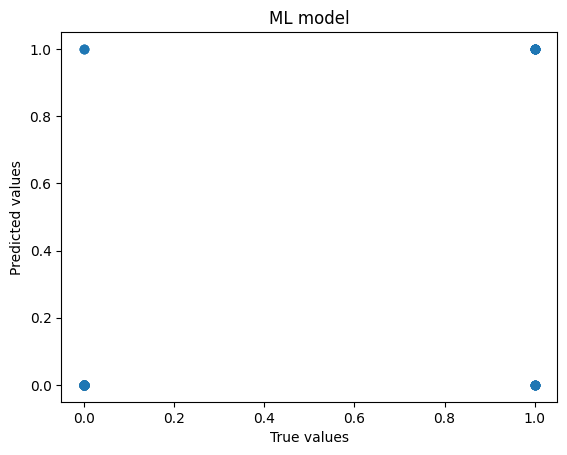

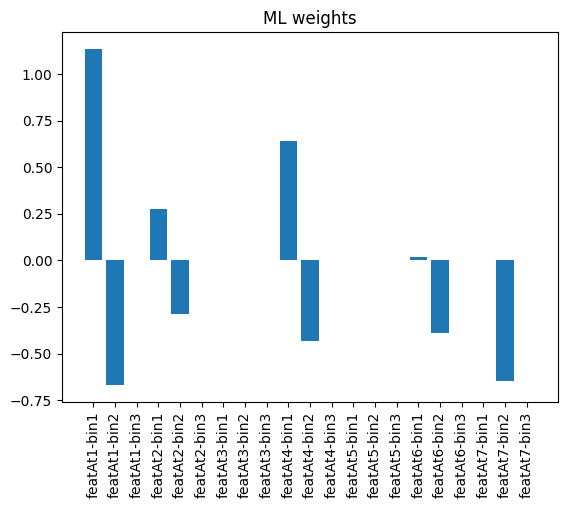

num of non-zero weights:  9
num of zero weights:  12
         Feature    Weight
0   featAt1-bin1  1.135006
1   featAt1-bin2 -0.668868
3   featAt2-bin1  0.276145
4   featAt2-bin2 -0.288901
9   featAt4-bin1  0.638321
10  featAt4-bin2 -0.432466
15  featAt6-bin1  0.018483
16  featAt6-bin2 -0.389598
19  featAt7-bin2 -0.649341


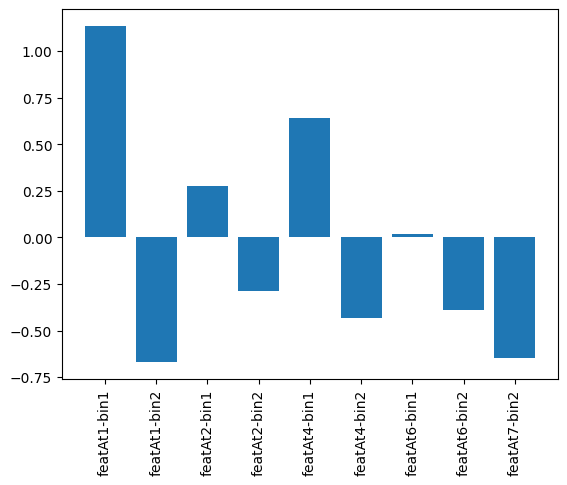

In [71]:
app_model_caim_1ook_rss, app_weights_caim_1ook_rss = scorecard(app_X, app_y, discretize_caim, disc_1_out_of_k, max_likelihood)